
--- NETWORK STATISTICS ---
Running 200 simulations...


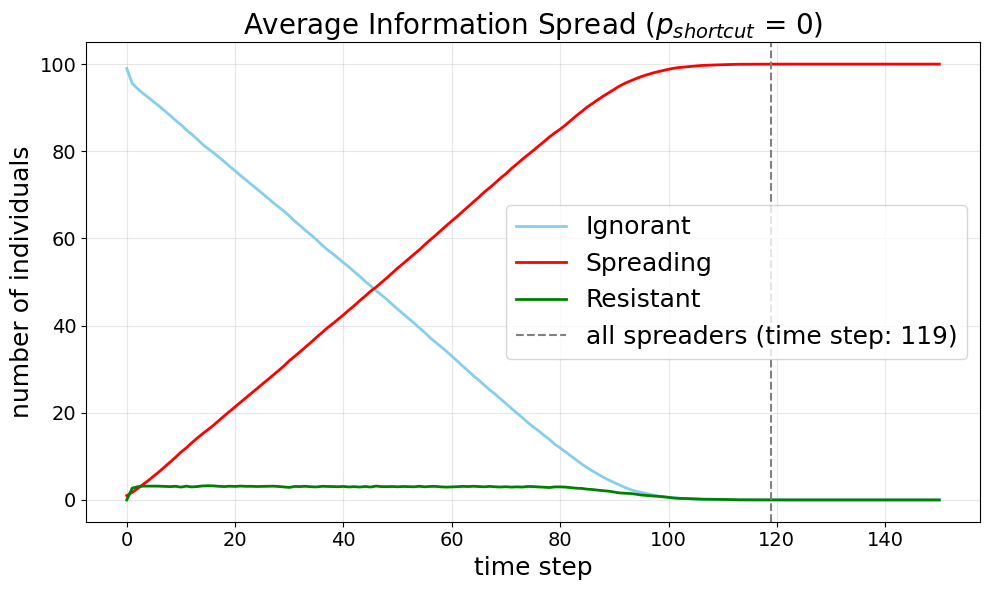

/var/folders/fn/201gwvqd56qg7ym5hwwcwp6c0000gn/T/ipykernel_51261/767083384.py:222: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


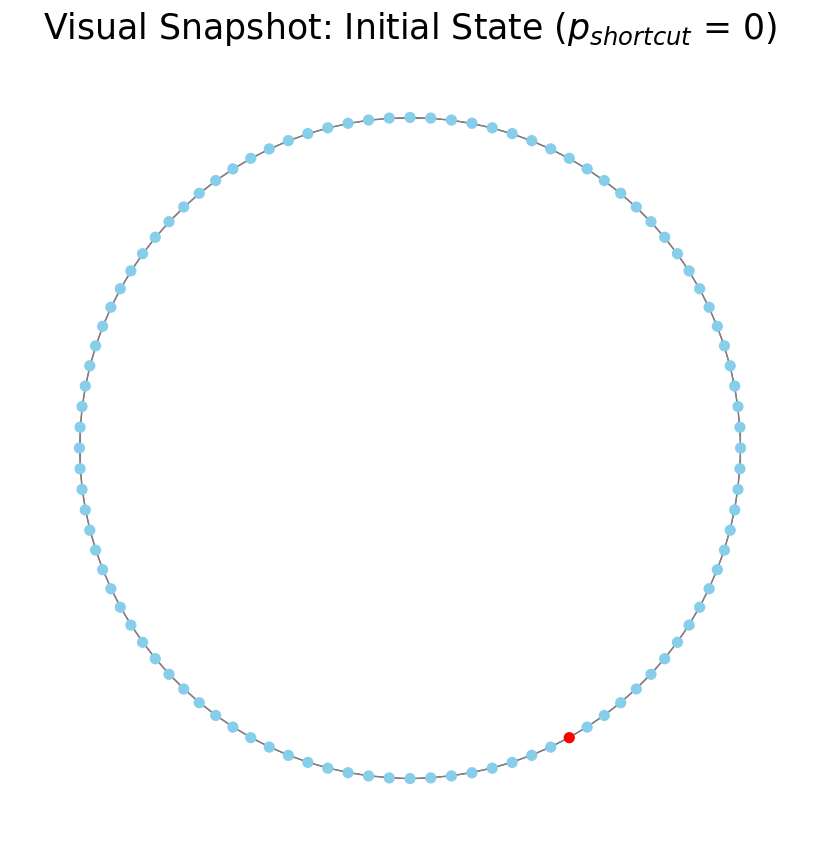

/var/folders/fn/201gwvqd56qg7ym5hwwcwp6c0000gn/T/ipykernel_51261/767083384.py:244: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


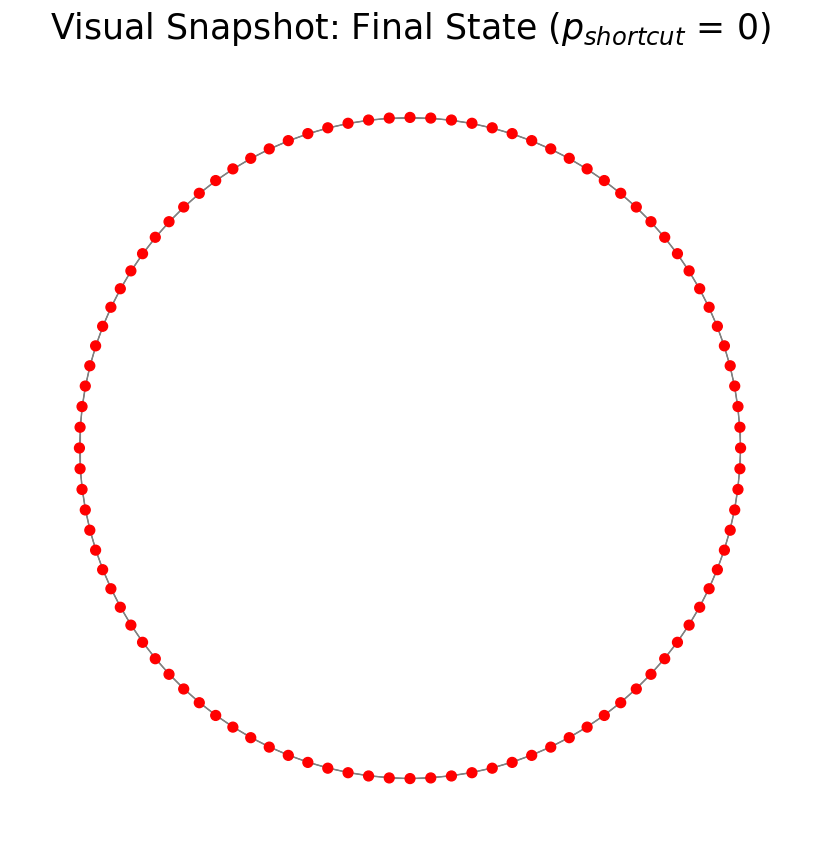


--- NETWORK STATISTICS ---
Running 200 simulations...


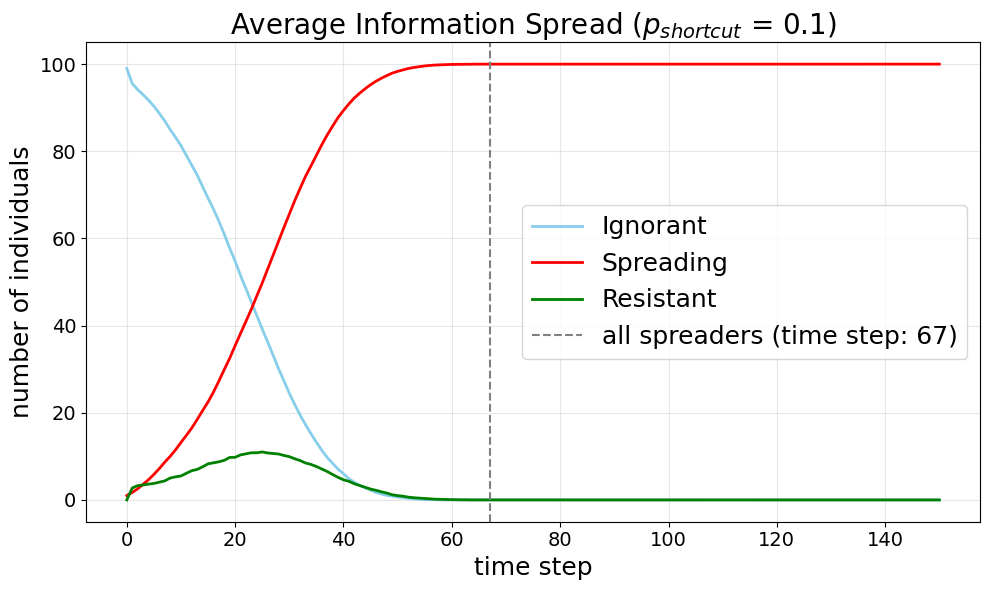

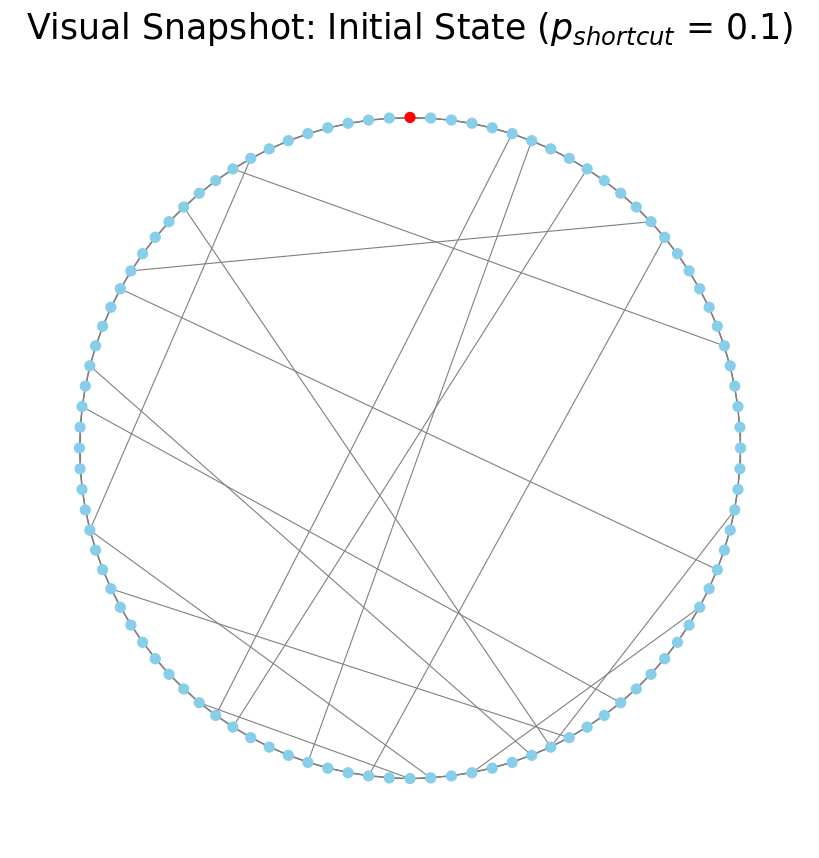

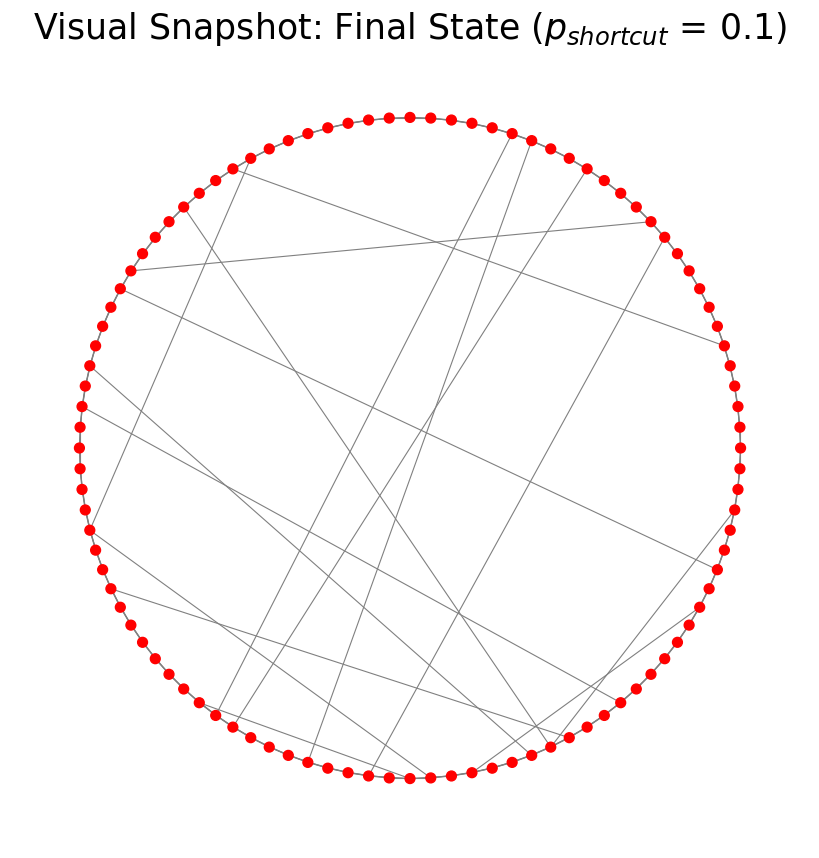


--- NETWORK STATISTICS ---
Running 200 simulations...


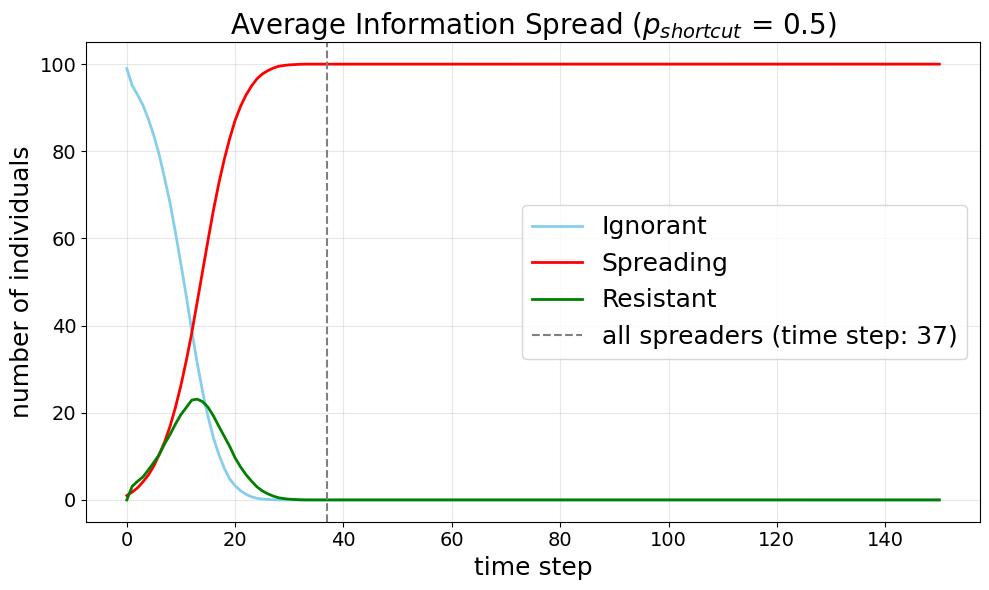

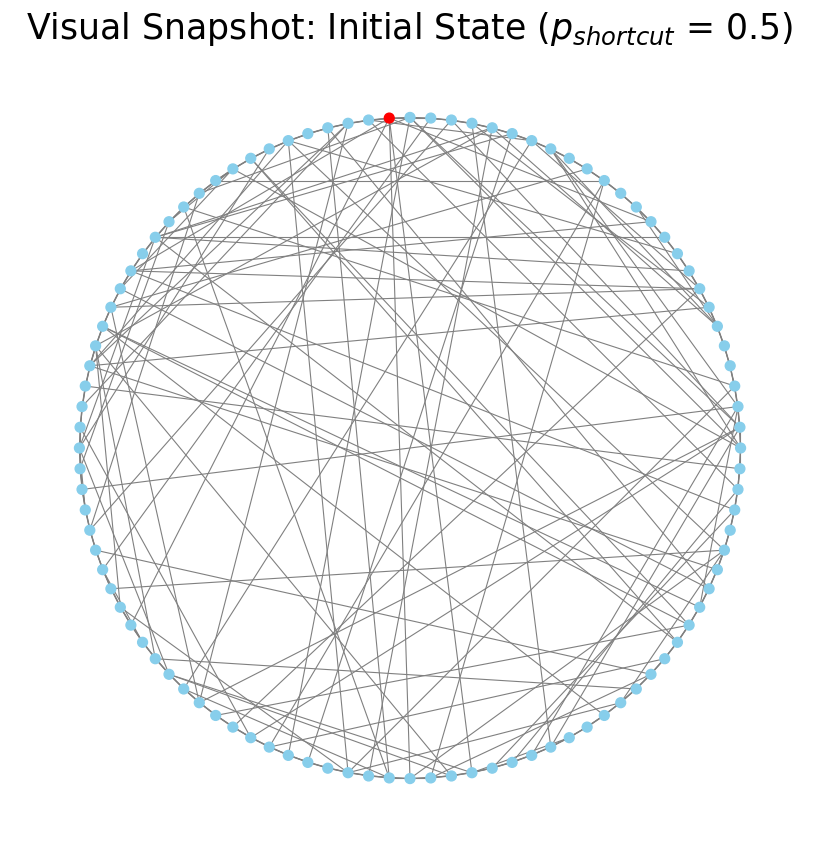

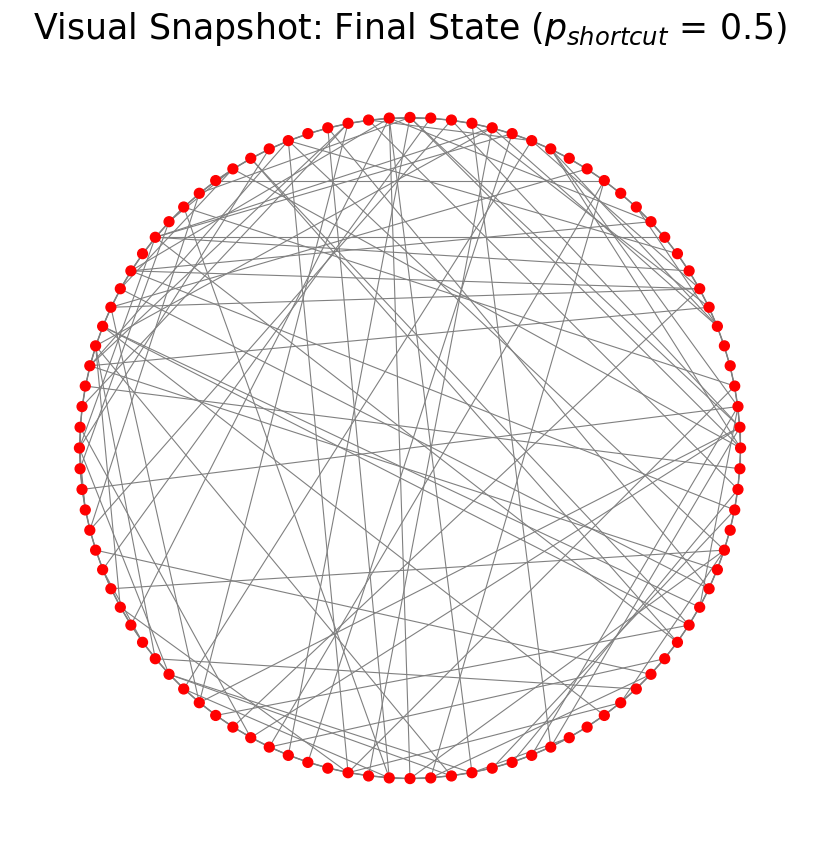


--- NETWORK STATISTICS ---
Running 200 simulations...


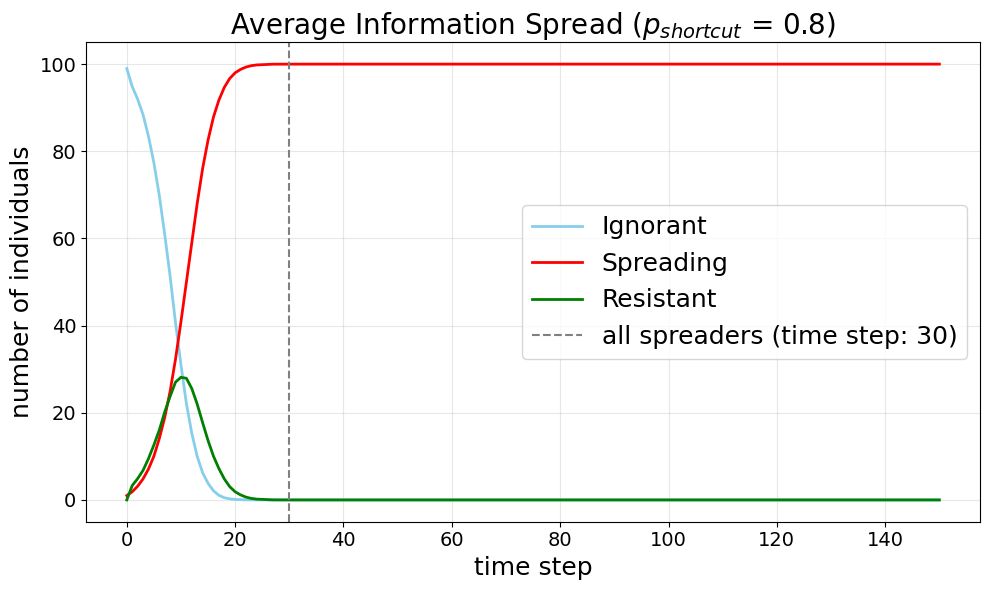

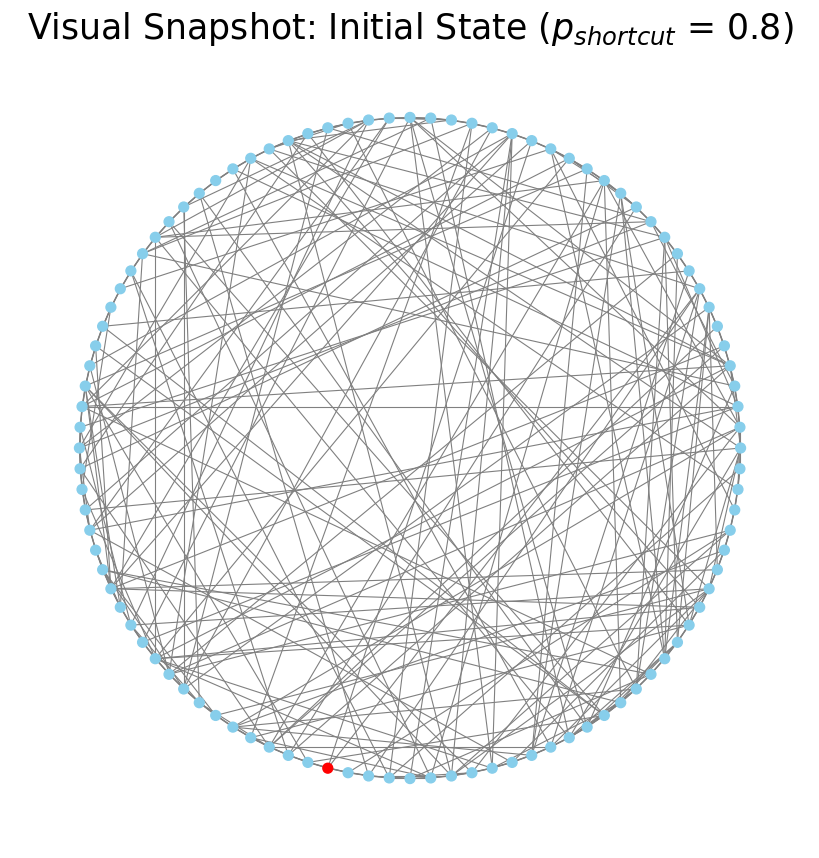

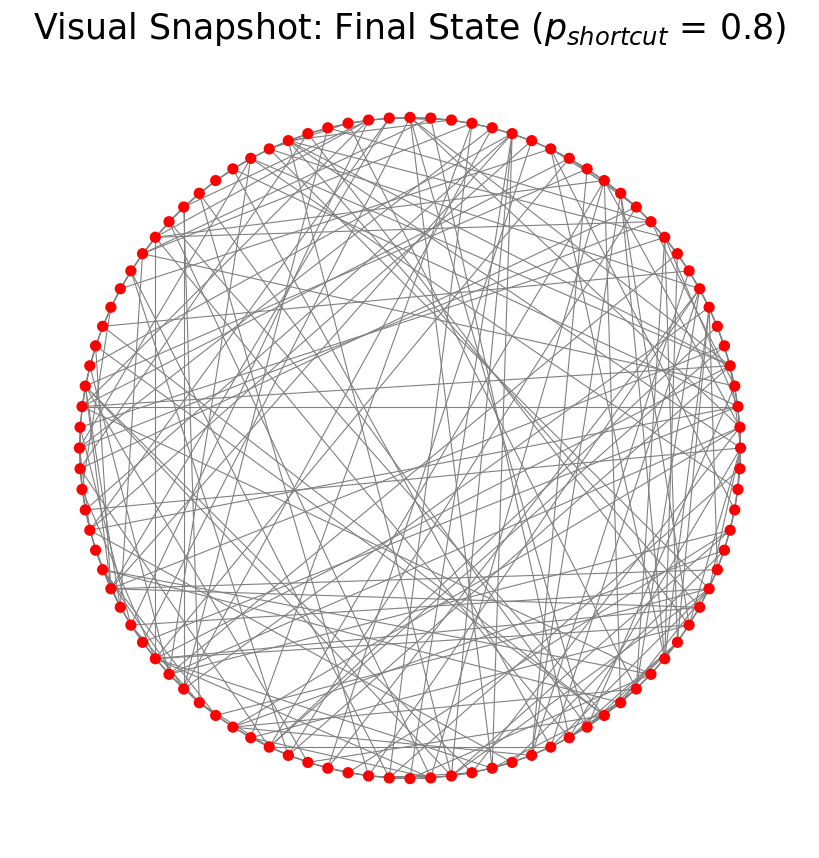

/var/folders/fn/201gwvqd56qg7ym5hwwcwp6c0000gn/T/ipykernel_51261/767083384.py:293: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot([all_critical_time_steps[0], all_critical_time_steps[1], all_critical_time_steps[2], all_critical_time_steps[3]], labels=['0', '0.1', '0.5', '0.8'])


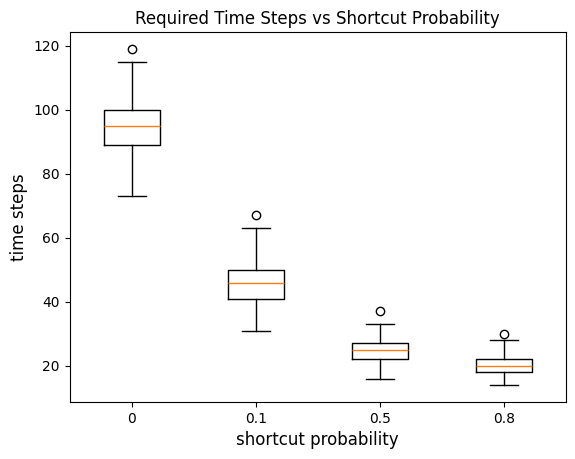

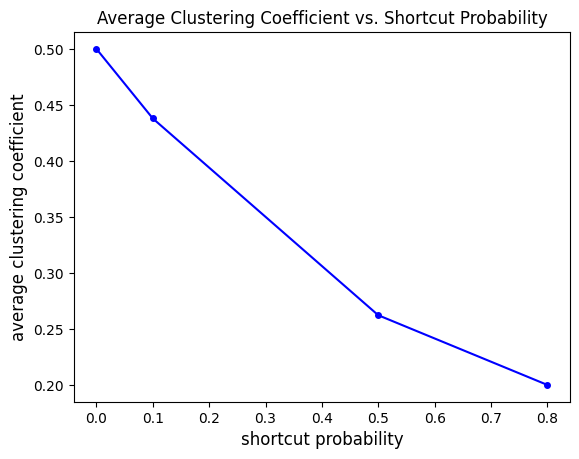

Text(0.5, 1.0, 'Average Path Length vs. Shortcut Probability')

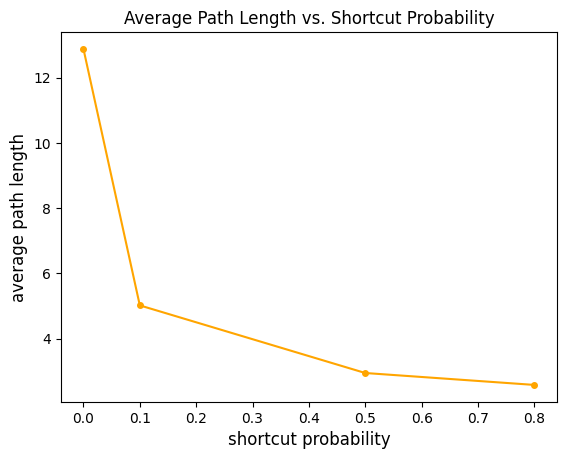

In [30]:
import networkx as nx
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import random
import numpy as np

# ==========================================
#        PART 1: HELPER FUNCTIONS
# ==========================================

def get_ring_distance(N, node_a, node_b):
    """
    Calculates the shortest distance along the ring structure.
    """
    raw_dist = abs(node_a - node_b)
    return min(raw_dist, N - raw_dist)

def network_statistics(G): # behövs
    """
    Calculates and prints the scientific properties of the network.
    """
    print("\n--- NETWORK STATISTICS ---")
    
    # 1. Clustering Coefficient (Local Community Strength)
    C = nx.average_clustering(G)
    #print(f"Clustering Coefficient (C): {C:.4f}")
    #print("  -> High C means neighbors are friends with each other (Cliques).")
    
    # 2. Average Path Length (Global Efficiency)
    if nx.is_connected(G):
        L = nx.average_shortest_path_length(G)
        #print(f"Average Path Length (L):    {L:.4f}")
        #print("  -> Low L means information can cross the network quickly.")
    else:
        print("Average Path Length (L):    Infinite (Graph is not connected)")
    #print("--------------------------\n")

    return C, L

# ==========================================
#        PART 2: BUILD SOCIETY
# ==========================================

def build_society(n, k, p_shortcut): # Denna modifikation av den originala Watts-Strogatz modellen ger en mer realistisk bild av samhället
    """
    Constructs a Newman-Watts-Strogatz graph.
    Shortcuts are ADDED to the ring, preserving local structure.
    """
    G = nx.newman_watts_strogatz_graph(n, k, p_shortcut)
    pos = nx.circular_layout(G) # gör att cirkelstrukturen behålls
    return G, pos

# ==========================================
#        PART 3: SIMULATION LOGIC
# ==========================================

def run_single_simulation(G, start_node, p_spread_base, p_accept, max_steps):
    """
    Runs one instance of the rumor spread.
    Returns: 
      - history: List of [Blue, Red, Green] counts per step
      - status: The final state dictionary of all nodes
    """
    
    # 1. Setup
    if start_node is None:
        start_node = random.choice(list(G.nodes)) # väljer ut en random "spreader"
        
    status = {node: 'ignorant' for node in G.nodes} # sätter alla initallt till ignorant i en "dictionary"
    status[start_node] = 'spreading' # men sätter en av dem till "spreader"
    
    spreading_nodes = [start_node] # lägger alla "spreaders" i en lista
    history = []
    
    # Record Step 0
    history.append([len(G.nodes)-1, 1, 0]) # initiallt en "spreader"

    # 2. Time Loop
    for t in range(max_steps):
        new_spreaders = []
        
        # Current Spreaders try to infect neighbors
        for carrier in spreading_nodes:
            neighbors = list(G.neighbors(carrier)) # för varje "spreader" så hittar vi dess neighbors
            
            for neighbor in neighbors:
                # We do NOT skip Green nodes (Social Reinforcement / Peer Pressure)
                # We only skip nodes that are already Red (converted)
                if status[neighbor] != 'spreading': # utför probabilistic spreading framework på "icke-spreaders"
                    
                    # A. Distance Logic: Probability decays with ring distance, probbilistic distance-dependent spreading
                    dist = get_ring_distance(len(G.nodes), carrier, neighbor)
                    p_effective = p_spread_base / dist**0.5 # misinformation is more likely to spread compared to the truth, so add dist^0.5
                    
                    # B. Check 1: Does the information travel?
                    if random.random() < p_effective:
                        
                        # C. Check 2: Does the receiver accept it?
                        if random.random() < p_accept:
                            # SUCCESS: They accept (Green or Blue becomes Red)
                            if status[neighbor] != 'spreading': # behövs inte, vi har redan villkoret där uppe
                                status[neighbor] = 'spreading'
                                new_spreaders.append(neighbor)
                        else:
                            # REJECTION: They reject (Blue or Green becomes Green)
                            status[neighbor] = 'resistant' # de accepterar inte den falska informationen och blir resistenta
        
        # Add new spreaders for the next turn
        spreading_nodes.extend(new_spreaders)
        
        # Record Stats
        n_red = list(status.values()).count('spreading')
        n_green = list(status.values()).count('resistant')
        n_blue = list(status.values()).count('ignorant')
        history.append([n_blue, n_red, n_green])
        
        # Optimization: Stop if everyone is Red
        if n_blue == 0 and n_green == 0:
            time_all_infected = t + 1 # det tidsteget där alla är "smittade", ska användas för box-plotsen
            last_state = [n_blue, n_red, n_green]
            for _ in range(max_steps - t - 1):
                history.append(last_state)
            break
            
    # Pad history to ensure consistent length for averaging
    while len(history) < max_steps + 1:
        history.append(history[-1])

    return history, status, time_all_infected

# ==========================================
#        PART 4: BATCH ANALYSIS & PLOTTING
# ==========================================
p_shortcut=0.1

def analyze_society(G, pos, runs, p_spread_base, p_accept):
    print(f"Running {runs} simulations...")
    
    G_initial = G.copy()
    max_steps = 150
    all_histories = []
    all_first_occurence_all_infected = []
    final_status_sample = None # To store the last run for visualization 

    # 1. Run Batch
    for i in range(runs):
        hist, status, first_occurence_all_infected = run_single_simulation(G, None, p_spread_base, p_accept, max_steps)
        all_histories.append(hist)
        all_first_occurence_all_infected.append(first_occurence_all_infected)
        final_status_sample = status

    
    # 2. Average Data
    data_np = np.array(all_histories)
    avg_history = np.mean(data_np, axis=0)
    
    avg_blue = avg_history[:, 0] # takes the average over all the runs for each time step
    avg_red = avg_history[:, 1]
    avg_green = avg_history[:, 2]

    
    # 3. Generate Plots
    
    # --- PLOT 1: SPREAD OVER TIME (Line Graph) --- Plots the number of susceptible, infected and recovered over all time steps in one plot
    plt.figure(figsize=(10, 6))
    steps = range(len(avg_blue))    

    plt.plot(steps, avg_blue, label='Ignorant', color='skyblue', linewidth=2)
    plt.plot(steps, avg_red, label='Spreading', color='red', linewidth=2)
    plt.plot(steps, avg_green, label='Resistant', color='green', linewidth=2)

    for step in steps: # to show at what time step the first occurence of all red nodes happens. Will give an indication of the diffusion rate for different small-world networks
        if avg_red[step] == len(G.nodes):
            plt.axvline(step, label = f'all spreaders (time step: {step})', color = 'gray', linestyle = '--')
            break
    
    plt.title(f"Average Information Spread ($p_{{shortcut}}$ = {p_shortcut})", fontsize=20)
    plt.xlabel("time step", fontsize=18)
    plt.ylabel("number of individuals", fontsize=18)
    plt.xticks(fontsize=14)
    plt.yticks(fontsize=14)
    plt.legend(fontsize=18)
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.show()
    
    # --- PLOT 2: REQUIRED TIME STEPS FOR COMPLETE SPREAD FOR EVERY INDIVIDUAL RUN (Box plot) ---
    #plt.figure(figsize=(8, 6))
    #intermediate_time_step = 25
    #intermediate_blue = avg_blue[intermediate_time_step]
    #intermediate_red = avg_red[intermediate_time_step]
    #intermediate_green = avg_green[intermediate_time_step]
    
    #categories = ['Ignorant', 'Spreading', 'Resistant']
    #values = [intermediate_blue, intermediate_red, intermediate_green]
    #colors = ['skyblue', 'red', 'green']
    
    #plt.bar(categories, values, color=colors, alpha=0.8)
    #plt.title("Average intermediate State (time step: 25)")
    #plt.ylabel("Count")
    # Add number labels on top of bars
    #for i, v in enumerate(values):
       # plt.text(i, v + 0.5, f"{v:.1f}", ha='center')
        
    #plt.tight_layout()
    #plt.show()

    # --- PLOT 3: NETWORK VISUALIZATION (Snapshot) --- the before and after snapshots
    
    plt.figure(figsize=(8, 8))
    color_map = ['skyblue'] * len(G.nodes)
    color_map[random.randint(0, len(G.nodes) - 1)] = 'red'
    nx.draw(G_initial, pos, 
            node_color = color_map, 
            with_labels = False,
            node_size = 50, 
            edge_color = 'gray', 
            width = 0.8)
    
    plt.title(f"Visual Snapshot: Initial State ($p_{{shortcut}}$ = {p_shortcut})", fontsize=25)
    plt.tight_layout()
    plt.show()
    
    plt.figure(figsize=(8, 8))
    color_map = []
    for node in G.nodes:
        s = final_status_sample[node]
        if s == 'spreading':
            color_map.append('red')
        elif s == 'resistant':
            color_map.append('green')
        else:
            color_map.append('skyblue')
            
    nx.draw(G, pos,
            node_color=color_map, 
            with_labels=False, 
            node_size=50, 
            edge_color='gray',
            width=0.8)
            
    plt.title(f"Visual Snapshot: Final State ($p_{{shortcut}}$ = {p_shortcut})", fontsize=25)
    plt.tight_layout()
    plt.show()

    return all_first_occurence_all_infected


# ==========================================
#        USER CONTROLS
# ==========================================

# 1. SETUP THE SOCIETY
# --------------------
# n = Total Nodes
# k = Neighbors (4 means 2 left, 2 right)
# p_shortcut = Probability of adding a shortcut per edge


#my_society, my_layout = build_society(n=100, k=4, p_shortcut=p_shortcut)

# 2. CALCULATE STATISTICS
# -----------------------
# This gives you the "Scientific" values (C and L) for your report
#network_statistics(my_society)

# 3. RUN THE EXPERIMENT
# ---------------------
# p_spread_base = Base chance to spread to neighbor (dist=1). 
#                 Divides by distance for shortcuts. (e.g. 1.2 / 1 = 100% chance)
# p_accept = Chance to accept the information if it arrives. - constant probability
#analyze_society(G=my_society, pos=my_layout, runs=200, p_spread_base=1, p_accept=0.2)

# 4. Iterate the analyze_society function for different p_shortcut
C_list = []
a_list = []
all_critical_time_steps = []
p_shortcut_list = [0, 0.1, 0.5, 0.8]

for p_shortcut in p_shortcut_list:
    my_society, my_layout = build_society(n=100, k=4, p_shortcut=p_shortcut)
    
    C, a = network_statistics(my_society)
    C_list.append(C)
    a_list.append(a)

    critical_time_steps = analyze_society(G=my_society, pos=my_layout, runs=200, p_spread_base=1, p_accept=0.2)
    all_critical_time_steps.append(critical_time_steps)


# diffusion rates as a function of shortcut probability (box plots)
plt.boxplot([all_critical_time_steps[0], all_critical_time_steps[1], all_critical_time_steps[2], all_critical_time_steps[3]], labels=['0', '0.1', '0.5', '0.8'])
plt.xlabel('shortcut probability', fontsize=12)
plt.ylabel('time steps', fontsize=12)
plt.title("Required Time Steps vs Shortcut Probability")

plt.show()

# average clustering coefficient and average path length as a function of shortcut probability (normal plots)
plt.plot(p_shortcut_list, C_list, '-o', color = 'blue', markersize=4)
plt.xlabel('shortcut probability', fontsize=12)
plt.ylabel('average clustering coefficient', fontsize=12)
plt.title('Average Clustering Coefficient vs. Shortcut Probability')

plt.show()

plt.plot(p_shortcut_list, a_list, '-o', color = 'orange', markersize=4)
plt.xlabel('shortcut probability', fontsize=12)
plt.ylabel('average path length', fontsize=12)
plt.title('Average Path Length vs. Shortcut Probability')

In [31]:
C_list

[0.5, 0.43799999999999994, 0.2625396825396825, 0.2004025974025974]

In [32]:
a_list

[12.878787878787879, 5.015555555555555, 2.942222222222222, 2.576969696969697]